# Introduction

The purpose of this analysis is to investigate whether school performance, measured by average ACT scores, is influenced by socioeconomic factors. Specifically, we examine the relationships between ACT scores and variables such as community education level, household income, unemployment rate, family structure, and student poverty. Understanding these patterns can provide insight into how socioeconomic conditions affect educational outcomes.

### Data Sources:

EdGap_data.xlsx (https://github.com/brian-fischer/DATA-5100/blob/main/EdGap_data.xlsx)

school_information  school_informatiom_sch_029_1617_w_1a_11212017.csv (https://www.dropbox.com/scl/fi/fkafjk8902sq8ptxh94r2/school_informatiom_sch_029_1617_w_1a_11212017.csv?rlkey=gucrdz5f6e38bezz2y3yalxbw&e=1&dl=0
)



## Data loading and Cleaning

We load the datasets, inspect them for structure and content, and clean them by removing duplicates, handling missing values, and filtering out-of-range scores and income values. This ensures our analysis is based on accurate and complete data.

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

from sklearn.preprocessing import StandardScaler
import plotly.express as px
import statsmodels.api as sm

# Load datasets
edgap = pd.read_excel('../data/EdGap_data.xlsx', dtype={'NCESSCH School ID': str})
school_information = pd.read_csv('../data/ccd_sch_029_1617_w_1a_11212017.csv', encoding='unicode_escape')

# Inspect first few rows
edgap.head(3)
school_information.head(3)

# Inspect info
edgap.info()
school_information.info()


/opt/anaconda3/lib/python3.13/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning:

Unknown extension is not supported and will be removed

/var/folders/wx/0m6_v4n9285892l822ksy8740000gn/T/ipykernel_80552/2623823479.py:13: DtypeWarning:

Columns (6,9,14,15,18,19,21,22,25,26,29,31,35,39,41,42) have mixed types. Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NCESSCH School ID                                7986 non-null   object 
 1   CT Unemployment Rate                             7972 non-null   float64
 2   CT Pct Adults with College Degree                7973 non-null   float64
 3   CT Pct Childre In Married Couple Family          7961 non-null   float64
 4   CT Median Household Income                       7966 non-null   float64
 5   School ACT average (or equivalent if SAT score)  7986 non-null   float64
 6   School Pct Free and Reduced Lunch                7986 non-null   float64
dtypes: float64(6), object(1)
memory usage: 436.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 65 columns):
 #   Column               N

## Data Cleaning

We remove duplicates, handle missing values, and filter out-of-range values for ACT scores and household income.

In [256]:
# Remove duplicates
edgap = edgap.drop_duplicates()
school_information = school_information.drop_duplicates(subset=['NCESSCH'])

# Filter ACT scores and income
edgap = edgap[(edgap['School ACT average (or equivalent if SAT score)'] >= 0) &
              (edgap['School ACT average (or equivalent if SAT score)'] <= 36)]
edgap = edgap[(edgap['CT Median Household Income'] >= 0)]

# Keep meaningful school types
school_information = school_information[school_information['SCH_TYPE_TEXT'].isin([
    'Regular School', 'Career And Technical School', 'Alternative School'
])]

# Remove rows missing school IDs
school_information = school_information[school_information['NCESSCH'].notna()]

# Drop missing values in key columns
edgap = edgap.dropna(subset=[
    'CT Unemployment Rate',
    'CT Pct Adults with College Degree',
    'CT Pct Childre In Married Couple Family',
    'CT Median Household Income',
    'School ACT average (or equivalent if SAT score)',
    'School Pct Free and Reduced Lunch'
])

school_information = school_information.dropna(subset=['NCESSCH', 'SCH_NAME'])

# Reset indices
edgap = edgap.reset_index(drop=True)
school_information = school_information.reset_index(drop=True)

print("EdGap shape after cleaning:", edgap.shape)
print("School Information shape after cleaning:", school_information.shape)


EdGap shape after cleaning: (7958, 7)
School Information shape after cleaning: (98614, 65)


## Merge Dataset and Preparation

We merge the two datasets and create derived variables for easier interpretation.

In [257]:
# Keep relevant columns from school_information
school_information = school_information[
    ['SCHOOL_YEAR', 'NCESSCH', 'LSTATE', 'LZIP', 'SCH_TYPE_TEXT', 'LEVEL', 'CHARTER_TEXT']
]

# Rename columns for clarity
edgap = edgap.rename(columns={
    'NCESSCH School ID': 'id',
    'CT Pct Adults with College Degree': 'percent_college',
    'CT Unemployment Rate': 'rate_unemployment',
    'CT Pct Childre In Married Couple Family': 'percent_married',
    'CT Median Household Income': 'median_income',
    'School ACT average (or equivalent if SAT score)': 'act_average',
    'School Pct Free and Reduced Lunch': 'percent_lunch'
})

school_information = school_information.rename(columns={
    'SCHOOL_YEAR': 'school_year',
    'NCESSCH': 'id',
    'LSTATE': 'state',
    'LZIP': 'zip_code',
    'SCH_TYPE_TEXT': 'school_type',
    'LEVEL': 'school_level',
    'CHARTER_TEXT': 'charter'
})

# Convert IDs to string and remove '.0'
edgap['id'] = edgap['id'].astype(str).str.replace(r'\.0$', '', regex=True)
school_information['id'] = school_information['id'].astype(str).str.replace(r'\.0$', '', regex=True)

# Merge datasets
df = edgap.merge(school_information, how='left', on='id')

# Derived variables
df['income_k'] = df['median_income'] / 1000
median_act = df['act_average'].median()
df['act_vs_median'] = df['act_average'] - median_act

df.head()


,id,rate_unemployment,percent_college,percent_married,median_income,act_average,percent_lunch,school_year,state,zip_code,school_type,school_level,charter,income_k,act_vs_median
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High,Yes,42.820,0.033455
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High,No,89.320,-0.901832
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High,No,84.140,-0.845665
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High,No,56.500,-2.662515
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High,No,54.015,-2.154579


In [258]:
# Income in thousands (easier to interpret)
df['income_k'] = df['median_income'] / 1000

# ACT score difference from median
median_act = df['act_average'].median()
df['act_vs_median'] = df['act_average'] - median_act

df.head()

,id,rate_unemployment,percent_college,percent_married,median_income,act_average,percent_lunch,school_year,state,zip_code,school_type,school_level,charter,income_k,act_vs_median
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High,Yes,42.820,0.033455
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High,No,89.320,-0.901832
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High,No,84.140,-0.845665
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High,No,56.500,-2.662515
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High,No,54.015,-2.154579


### Export Cleaned Data

In [259]:
# Define file name and directory
output_file = "../data/cleaned_education_data.csv"

# Export to CSV 
df.to_csv(output_file, index=False)

print(f"Final data shape: {df.shape}")


Final data shape: (7958, 15)


## Exploratory Analysis

+ Median Household Income VS ACT Scores



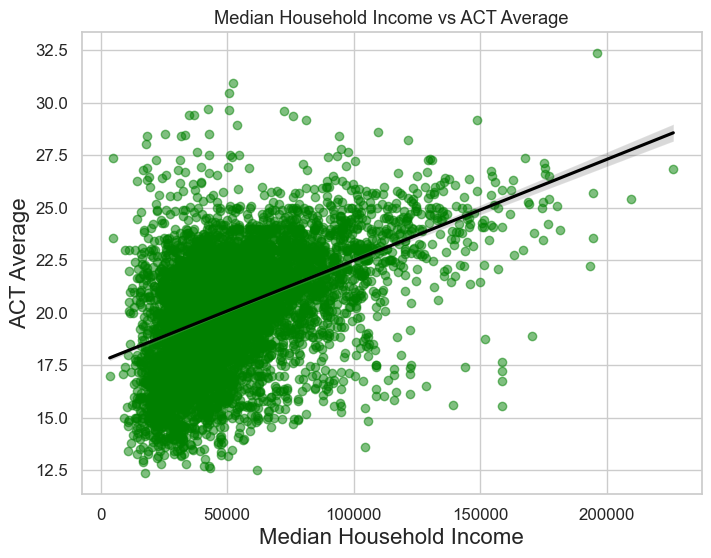

In [260]:
#Median Household Income vs. ACT Average:
plt.figure(figsize=(8,6))

sns.regplot(x='median_income', y='act_average', data=df, scatter_kws={'alpha':.5, 'color': 'green'}, color= 'black')
plt.title('Median Household Income vs ACT Average')
plt.xlabel('Median Household Income', fontsize = 16)
plt.ylabel('ACT Average', fontsize = 16)
plt.show()



The plot shows a positive correlation between median household income and ACT scores: schools in wealthier areas tend to have higher ACT averages. Most schools fall in the $25,000–$125,000 income range with ACT scores between 17.5 and 27.5. While the trend is clear, scores vary at all income levels, indicating that income is not the only factor influencing performance.

+ Average ACT Score by State

In [261]:
# Average ACT Score by State
state_avg = df.groupby('state')['act_average'].mean().reset_index()
fig = px.choropleth(state_avg, 
                    locations='state', 
                    locationmode="USA-states", 
                    color='act_average', 
                    scope="usa",
                    color_continuous_scale="Viridis",
                    labels={'act_average':'ACT Average'})
fig.update_layout(title_text='Average ACT Score by State')
fig.show()


Average ACT Score by State

The map shows state-level average ACT scores using a Viridis color scale: darker colors indicate lower scores (~18), and lighter colors indicate higher scores (~21+).

Key Observations:

Lowest scores: Concentrated in the Southeastern states (e.g., Louisiana, Mississippi, Alabama).

Highest scores: Seen in parts of the Midwest (e.g., Michigan, Wisconsin), the Western U.S. (e.g., Washington), and some Northeastern states (e.g., Massachusetts, Connecticut).

Mid-range scores: Spread across the Midwest and Southwest.

Missing data: Some states appear uncolored, likely due to reporting gaps or preference for SAT over ACT.

## Lenear Regression Analysis

We use OLS regression to quantify relationships between ACT scores and socioeconomic predictors.



In [262]:
# Select predictors and target
x = df[['median_income', 'percent_college', 'percent_married','rate_unemployment', 'percent_lunch']]
y = df['act_average']

# Add constant
x_const = sm.add_constant(x)

# Fit model
model = sm.OLS(y, x_const).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     2605.
Date:                Sat, 18 Oct 2025   Prob (F-statistic):               0.00
Time:                        21:21:24   Log-Likelihood:                -14892.
No. Observations:                7958   AIC:                         2.980e+04
Df Residuals:                    7952   BIC:                         2.984e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                22.6664      0.13

+ R-squared ~62% → the model explains 62% of ACT score variance.

+ Significant predictors:

   + Percent of adults with college degrees (+)

   + Rate of unemployment (-)

   + Percent of students on free/reduced lunch (-)

### Scaled Predictors
 
 Scaling allows us to compare relative strength of predictors.

In [263]:

# --- Select predictor variables ---
x = df[['median_income', 'percent_college', 'percent_married', 'rate_unemployment', 'percent_lunch']]
y = df['act_average']

# --- Scale the predictors ---
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Convert back to DataFrame to keep column names
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

# --- Add constant for statsmodels ---
x_scaled = sm.add_constant(x_scaled)

# --- Fit OLS regression ---
model = sm.OLS(y, x_scaled).fit()

# --- Summary ---
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     2605.
Date:                Sat, 18 Oct 2025   Prob (F-statistic):               0.00
Time:                        21:21:24   Log-Likelihood:                -14892.
No. Observations:                7958   AIC:                         2.980e+04
Df Residuals:                    7952   BIC:                         2.984e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                20.1893      0.01

+ Student poverty (percent_lunch) has the largest standardized coefficient → strongest impact.

+ Percent of adults with college degrees (+) and unemployment (-) are also significant.

+ Median income and percent of children in married-couple families are not significant after controlling for other factors.

### Summary and Final Conclusions

+ School performance, measured by ACT scores, is influenced by socioeconomic factors.

+ Positive predictor: Percent of adults with college degrees.

+ Negative predictors: Student poverty and local unemployment.

+ Median household income and percent of children in married-couple families are not significant.

+ Overall, the model explains ~62% of the variation in ACT scores.

+ Scaling shows student poverty has the largest relative impact on performance.

### Conclusion:
Community education, student poverty, and unemployment are the strongest predictors of school performance. Addressing economic disadvantage could improve ACT outcomes across schools.